### Helpers

In [18]:
# %load_ext autoreload
# %autoreload 2

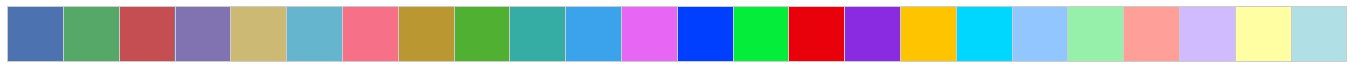

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as sts
import seaborn as sns
from IPython.display import display
from common import *
from io_tools import (
    read_train, read_pub_test, read_pvt_test,
    convert_train, convert_pub_test, convert_pvt_test,
)
from pipeline import (
    split_classes, count_classes, sample,
    cross_validate, fit_predict_save, fit_save_model
)
from transformers.pca import pca_fit, pca_transform
from transformers.cosine import add_coses, to_degrees
from transformers.momentum import add_is_muon, add_is_muon_tight, add_probability_hit_detector
from transformers.err import add_mse, add_normed_err, err_cols

sns.set()
sns.set_style("whitegrid")

color_palette = sns.color_palette('deep') + sns.color_palette('husl', 6) + sns.color_palette('bright') + sns.color_palette('pastel')

%matplotlib inline
sns.palplot(color_palette)

def ndprint(a, precision=3):
    with np.printoptions(precision=precision, suppress=True):
        print(a)

### Reading

In [2]:
# derivative cols

In [118]:
%%time
used_cols = xyz_cols + mom_cols + hit_type_cols + dxyz_cols + exy_cols + edxy_cols + hit_stats_cols + t_cols + ncl_cols + avg_cs_cols
train = read_train(used_cols, 1000000)
display(train.shape, count_classes(train))

(1000000, 63)

(421218, 578782)

Wall time: 3.71 s


### Data transformer

Это по сути основная часть. Класс, который отбирает нужные столбцы, возможно что-то модифицирует или добавляет. На выходе - входные данные для модели.

In [7]:
dll_train = read_train(xy_cols + dx_cols + dy_cols + exy_cols, 10000000)

In [8]:
dll_train = add_mse(dll_train, [])

In [78]:
def create_pdfs(data):
    dts = [dt.loc[:, err_cols[0]] for dt in split_classes(data)]
    min_len = min(map(len, dts))
    nbins = int(round(np.sqrt(min_len) / np.pi))
    nbins = 230
    
    l, r = np.min(data[err_cols[0]]) - 1e-5, np.max(data[err_cols[0]]) + 1e-5
    k = 9
    m = (r - l) / k
    m = 20
    bins = np.concatenate((
        np.arange(l, 1, .02),
        np.arange(1, 3, .04),
        np.arange(3, 10, .1),
        np.arange(10, 16, .4),
        np.arange(16, 34, 1.),
        np.arange(34, 66, 2),
        np.arange(66, 120, 5.),
        np.linspace(120, r, 3),
    ))
    nbins = len(bins)
    print(nbins)
#     bins = np.concatenate((
#         np.linspace(l, m, (k-1) * nbins // k, endpoint=False), 
#         np.linspace(m, r, nbins // k)
#     ))
    pdfs = []
    
    for i in range(2):
        pdf, _ = np.histogram(dts[i], bins=bins)
        pdfs.append(pdf)
                       
    return pdfs, bins
                       
pdfs, bins = create_pdfs(dll_train)

233


In [ ]:
pdfs

In [83]:
def add_dll(data, features):
    def get_probs(pdf, x):
        indices = np.digitize(x, bins) - 1
        wbin = (bins[indices + 1] - bins[indices]) / (np.max(bins) - np.min(bins))
        prob = pdf[indices] / pdf.sum()
        return prob #* wbin

    def get_dll(x):
        probs = [get_probs(pdf, x) for pdf in pdfs]
        DLL = np.log(probs[1]) - np.log(probs[0])
        return DLL

    data[err_cols[1]] = get_dll(data.loc[:, err_cols[0]])
    features += err_cols[1:2]
    return data

df_scores, feature_importance = cross_validate(train, n_estimators=60, n_splits=3, n_rows=10000, transformer_cls=DataTransformer)
display(df_scores.describe())

,acc,prec,rec,f1,roc_auc,scr,th,dTh
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
mean,0.774200,0.765252,0.878637,0.818021,0.795253,0.706133,0.101220,0.000250
std,0.003780,0.004446,0.005471,0.002866,0.004645,0.133089,0.000327,0.000433
min,0.770177,0.760216,0.872793,0.815511,0.790215,0.595601,0.100870,0.000000
25%,0.772461,0.763561,0.876137,0.816459,0.793198,0.632268,0.101072,0.000000
50%,0.774745,0.766907,0.879481,0.817408,0.796181,0.668935,0.101273,0.000000
75%,0.776211,0.767770,0.881558,0.819276,0.797773,0.761399,0.101395,0.000375
max,0.777678,0.768633,0.883636,0.821144,0.799365,0.853863,0.101518,0.000751


In [99]:
import numpy as np
from common import x_cols, y_cols, z_cols

da_cols = ['DAngle[%d]' % i for i in range(1, 4)]

def add_coses(data, features):
    def get_layer_coords(data, i):
        return data[[x_cols[i], y_cols[i], z_cols[i]]].values
  
    def dot(x, y):
        return np.sum(x * y, axis=1, dtype=np.float32)
    
    def norm(x):
        return np.sqrt(dot(x, x))

    def get_cosine_dist(L1, L2, L1_norm, L2_norm):
        cosines = dot(L1, L2) / L1_norm / L2_norm
        return np.clip(cosines, -1., 1.)
    
    layers = np.array([get_layer_coords(data, i) for i in range(4)])
    layers[1:] -= layers[:3]
    layers[0] = get_zero_point(data)
    
    for i in range(3):
        cur_layer = layers[i]
        next_layer = layers[i+1]
        nan_mask = np.isnan(next_layer[:, 0])
        next_layer[nan_mask, :] = cur_layer[nan_mask, :]
        
        cosines = get_cosine_dist(cur_layer, next_layer, norm(cur_layer), norm(next_layer))
        degrees = to_degrees(cosines)
        cosines[nan_mask] = np.NaN
        degrees[nan_mask] = np.NaN
        data[da_cols[i]] = degrees
        
    features += da_cols
    return data

def to_degrees(cosine):
    return np.arccos(cosine) / np.pi * 180.

def _to_degrees(cosines):
    angles = cosines.copy()
    isn_mask = ~np.isnan(cosines)
    angles[isn_mask] = np.arccos(cosines[isn_mask]) / np.pi * 180.
    return angles

def get_zero_point(data):
    layers = [data[[ex_cols[i], ey_cols[i], z_cols[i]]].values for i in range(2)]
    d = layers[1] - layers[0]
    return d
    
df_scores, feature_importance = cross_validate(train, n_estimators=60, n_splits=3, n_rows=10000, transformer_cls=DataTransformer)
display(df_scores.describe())

,acc,prec,rec,f1,roc_auc,scr,th,dTh
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.0
mean,0.771299,0.762550,0.875912,0.815285,0.797224,0.674820,0.088224,0.0
std,0.005184,0.006417,0.006680,0.003680,0.003183,0.108156,0.016137,0.0
min,0.765906,0.755148,0.868298,0.812229,0.795279,0.584042,0.077411,0.0
25%,0.768826,0.760553,0.873472,0.813242,0.795387,0.614986,0.078950,0.0
50%,0.771746,0.765957,0.878646,0.814254,0.795496,0.645930,0.080489,0.0
75%,0.773995,0.766251,0.879719,0.816812,0.798196,0.720209,0.093630,0.0
max,0.776245,0.766544,0.880791,0.819370,0.800897,0.794488,0.106772,0.0


In [134]:
feature_importance

,score
ErrMSE,0.166667
PT,0.130952
NShared,0.064286
DAngle[1],0.059524
DAngle[2],0.054762
Mextra_DX2[3],0.047619
DLL,0.038095
NErr_Y[3],0.033333
P,0.028571
NErr_X[0],0.023810


In [133]:
err_x_cols = ['Err_X[%i]' % i for i in range(N_STATIONS)]
err_y_cols = ['Err_Y[%i]' % i for i in range(N_STATIONS)]
err_z_cols = ['Err_Z[%i]' % i for i in range(N_STATIONS)]
err_xy_cols = err_x_cols + err_y_cols
err_xyz_cols = err_xy_cols + err_z_cols
ez = np.array([15270., 16470., 17670., 18870.])

def add_errs(data, features):
    for err_col, e_col, col in zip (err_xy_cols, exy_cols, xy_cols):
        data.loc[:, err_col] = data[e_col].values - data[col].values
        
    for i in range(4):
        data.loc[:, err_z_cols[i]] = ez[i] - data[z_cols[i]].values
    
    features += err_xyz_cols
    
df_scores, feature_importance = cross_validate(train, n_estimators=60, n_splits=3, n_rows=100000, transformer_cls=DataTransformer)
display(df_scores.describe())

,acc,prec,rec,f1,roc_auc,scr,th,dTh
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.0
mean,0.781290,0.772502,0.880623,0.823026,0.813209,0.735453,0.083527,0.0
std,0.001314,0.001441,0.000765,0.000935,0.002179,0.017820,0.001816,0.0
min,0.780254,0.771662,0.879792,0.822196,0.810708,0.715770,0.082011,0.0
25%,0.780551,0.771670,0.880286,0.822520,0.812463,0.727934,0.082520,0.0
50%,0.780848,0.771677,0.880779,0.822845,0.814219,0.740099,0.083030,0.0
75%,0.781808,0.772921,0.881039,0.823441,0.814459,0.745294,0.084285,0.0
max,0.782768,0.774166,0.881299,0.824038,0.814700,0.750489,0.085540,0.0


In [6]:
def add_mse(data, features):
#     dxy = (data.loc[:, xy_cols].values - data.loc[:, exy_cols].values) / data.loc[:, dx_cols + dy_cols].values / 2.
    xy_vals = data.loc[:, xy_cols].values

    dxy = (data.loc[:, xy_cols].values - data.loc[:, exy_cols].values) / data.loc[:, dx_cols + dy_cols].values / 2.
    D = np.nanmean(dxy**2, axis=1)
    
    data.loc[:, err_cols[0]] = D
    features += [err_cols[0]]
    return data

In [163]:
%%time
from sklearn.base import TransformerMixin

def filter_unimportant_features(features, fscore):
    return [col for col in features if col not in fscore.index or fscore.loc[col, 'score'] > 0.]
#     return features

class DataTransformer(TransformerMixin):
    def __init__(self, *featurizers):
        self.featurizers = featurizers
    
    def fit(self, data, y=None):
        return self

    def transform(self, data):
        data = data.copy()
        self.origin_features = [] + mom_cols + hit_type_cols + dxyz_cols + exy_cols + edxy_cols + hit_stats_cols + t_cols + ncl_cols + avg_cs_cols + xyz_cols
        self.origin_features = filter_unimportant_features(self.origin_features, global_feature_importance)
        features = self.origin_features.copy()

#         add_is_muon(data, features)
#         add_is_muon_tight(data, features)
#         add_probability_hit_detector(data, features)
        add_coses(data, features)
        add_mse(data, features)
        add_normed_err(data, features)
        add_dll(data, features)
        add_errs(data, features)
        
#         filter_data(data)
        if not features:
            raise('no features')
    
        self.features = features[len(self.origin_features):]
        self.features = filter_unimportant_features(self.features, global_feature_importance)
        return data[features].values

df_scores, feature_importance = cross_validate(train, n_estimators=60, n_splits=3, n_rows=1000, transformer_cls=DataTransformer)
display(df_scores.describe())
# display(feature_importance)

,acc,prec,rec,f1,roc_auc,scr,th,dTh
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.0
mean,0.743984,0.722172,0.896491,0.799830,0.778891,0.516798,0.141890,0.0
std,0.025416,0.023253,0.012155,0.016881,0.013505,0.074210,0.031066,0.0
min,0.714715,0.695473,0.889474,0.780600,0.770703,0.439122,0.110032,0.0
25%,0.735736,0.714262,0.889474,0.793642,0.771097,0.481712,0.126786,0.0
50%,0.756757,0.733051,0.889474,0.806683,0.771491,0.524302,0.143540,0.0
75%,0.758618,0.735521,0.900000,0.809445,0.782985,0.555636,0.157819,0.0
max,0.760479,0.737991,0.910526,0.812207,0.794479,0.586971,0.172099,0.0


Wall time: 2 s


### Test theory

In [156]:
%%time
df_scores, feature_importance = cross_validate(train, n_estimators=120, n_splits=5, n_rows=100000, transformer_cls=DataTransformer)
display(df_scores.describe())
# display(feature_importance)

,acc,prec,rec,f1,roc_auc,scr,th,dTh
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.0
mean,0.790120,0.783464,0.879909,0.828890,0.823175,0.776263,0.085720,0.0
std,0.001149,0.001157,0.001133,0.000898,0.001173,0.033495,0.002898,0.0
min,0.789261,0.782458,0.878321,0.828084,0.822129,0.743210,0.080796,0.0
25%,0.789311,0.782482,0.879436,0.828289,0.822261,0.757948,0.085507,0.0
50%,0.789739,0.783283,0.879792,0.828808,0.823184,0.766209,0.086955,0.0
75%,0.790240,0.783846,0.880994,0.828894,0.823238,0.783821,0.087368,0.0
max,0.792050,0.785251,0.881004,0.830376,0.825065,0.830128,0.087971,0.0


Wall time: 1min 51s


In [ ]:
display(feature_importance)

In [162]:
global_feature_importance = feature_importance.copy()

### Get result

In [104]:
test = read_pub_test(used_cols)

In [105]:
%%time
fit_predict_save(sample(train, 100000), test, "out/09_plus_all_orig_features_100.csv", n_estimators=120, transformer_cls=DataTransformer)

Wall time: 32.1 s


In [107]:
%%time
fit_predict_save(sample(train, 1000000), test, "out/09_plus_all_orig_features_1000_120.csv", n_estimators=120, transformer_cls=DataTransformer)

Wall time: 6min 57s


In [108]:
%%time
fit_predict_save(sample(train, 1000000), test, "out/09_plus_all_orig_features_1000_200.csv", n_estimators=200, transformer_cls=DataTransformer)

Wall time: 11min 39s


In [6]:
%%time
fit_save_model(sample(train, 100000), "models/07_dumb_cols.xgb", n_estimators=120, transformer_cls=DataTransformer)

Wall time: 11.5 s


### Scratches

In [410]:
a = pd.DataFrame([[1.0, np.NaN], [np.NaN, np.NaN], [2.0, 3.1]], columns=['a', 'b'])

In [5]:
from transformers.cosine import da_cols
from transformers.err import err_cols, nerr_xy_cols